# Titanic passengers classification using Ensemble Methods

## Artur Skowroński

### Description of the problem

"This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works." ~ Kaggle.
This task is considered to be one of the most known connected with Machine Learning and my task is to predict which passenger have/could survived.

The train dataset dimension is equal to 891 observations and 12 variables. The independent variable is "survived" where we can get an information if the passengers has survived (1) or not (0).

**Characteristic of each row**

* *Survival* - Survival (0 = No; 1 = Yes) **Target Variable**
* *Class* - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* *Name* - Name of passenger
* *Sex* - Gender of passenger
* *Age* - Age
* *Sibsp* - Number of Siblings/Spouses Aboard
* *Parch* - Number of Parents/Children Aboard
* *Ticket* - Ticket Number
* *Fare* - Passenger Fare
* *Cabin* - Cabin
* *Embarked* - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

## 1. Libraries

In [1]:
import os
import warnings 
warnings.filterwarnings('ignore')

# Handling the data
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno

# Modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

In [2]:
# Load titanic

os.chdir('')
titanic = pd.read_csv('train.csv')

## 2. Dataset

In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Setting the new column index
titanic.set_index("PassengerId", inplace = True)

In [5]:
# Quick glance into the data
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
# Basic statistics of the data
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Basing on the above table:
* *Survived* - probably everything is alright with this variable, however basing on the mean I suggest that more passengers has died
* *Pclass* - most of the passengers were having second or third class which is quite understandable
* *Age* - the youngest person hasn't even lived one year, while the age of the oldest one is equal 80. There are some missing values in this variable
* *Parch* - median is equal to 0.00 so at least 50% of the passengers were alone
* *Fare* - the price of the most expensive ticket is equal to 512 (probably 1st class), while the price of the cheapest one is equal to 0.00 (probably the youngest passenger or MAYBE it is some kind of an error - it is worth to check)

#### 2.1 Additional verification and formatting

In [7]:
# Checking if the value of sex is equal to prefixes of each person

temp_name = titanic['Name'].apply(lambda x: x.split(",")[1].split(".")[0])

check_titanic_gender = pd.DataFrame({'Prefix_of_passenger':temp_name, 'Gender':titanic['Sex']})
check_titanic_gender

,Prefix_of_passenger,Gender
PassengerId,,
1,Mr,male
2,Mrs,female
3,Miss,female
4,Mrs,female
5,Mr,male
...,...,...
887,Rev,male
888,Miss,female
889,Miss,female


There is some additional value 'Rev' in Prefix_of_passenger - let's check it.

In [8]:
check_titanic_gender['Prefix_of_passenger'].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
Name: Prefix_of_passenger, dtype: int64

Well, we see that there are many prefixes so let's **suppose** that everything is fine with this.

In [9]:
# Chaning the gender into 0-1 values, where 1 is female and 0 male
titanic['Sex'] = titanic['Sex'].apply(lambda x: 1 if x == 'female' else 0)
titanic['Sex'][0:5]

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Sex, dtype: int64

## 3. Clear the data

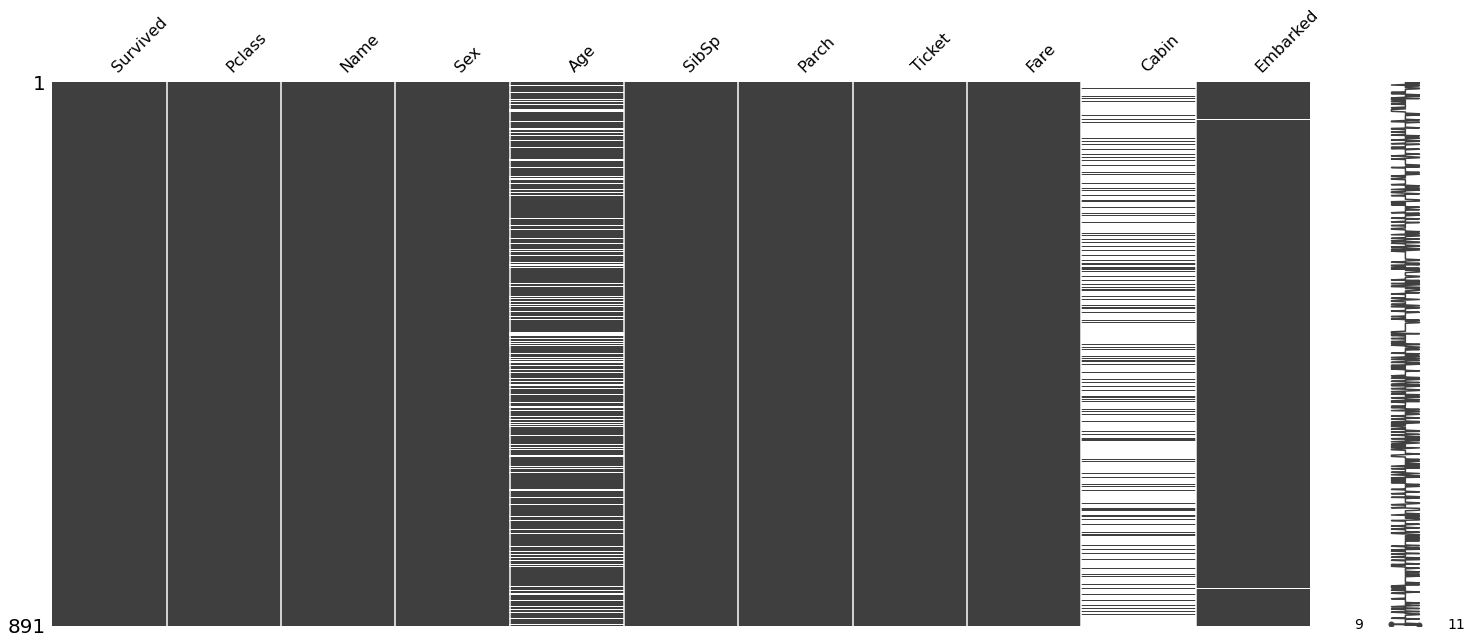

In [10]:
# Chart for missing data in each column
msno.matrix(titanic)
plt.show()

The problem with missing data extends across the entire set for the Age and Cabin variables.
It is not the best idea just to remove this data, that's why I will dive more into these two columns and check some dependencies.

### Age

I don't think that implementing median to each missing values is definitely the best idea.
So maybe it is worth to match the fares with age - I think that older people are more willing to pay more for tickets.
I will divide Fare into 4 buckets.

In [11]:
# Making of copy of original dataset and adding fare_cit
titanic_new = titanic.copy()

titanic_new['fare_cut'] = pd.cut(titanic_new['Fare'], bins = 4)

#Calcucalting the median fare for each age group
age_pivot = pd.pivot_table(titanic_new, values = 'Age', index = 'fare_cut', aggfunc = np.median)
age_pivot

,Age
fare_cut,
"(-0.512, 128.082]",28.0
"(128.082, 256.165]",36.0
"(256.165, 384.247]",22.0
"(384.247, 512.329]",35.0


Unfortunately, my hypothesis seems to be not quite true. Nevertheless, I will check additional how the medians are distributed with respect to the Parch variable.

In [12]:
# Checking the Parch column by each age group
pd.pivot_table(titanic_new, values = 'Age', index = 'fare_cut', columns = 'Parch', aggfunc = np.median)

Parch,0,1,2,3,4,5,6
fare_cut,,,,,,,
"(-0.512, 128.082]",29.0,21.0,12.5,24.0,40.0,39.0,43.0
"(128.082, 256.165]",37.0,41.5,25.0,NaN,NaN,NaN,NaN
"(256.165, 384.247]",NaN,NaN,21.0,NaN,64.0,NaN,NaN
"(384.247, 512.329]",35.0,36.0,NaN,NaN,NaN,NaN,NaN


In [13]:
# LabelEncoder of fare_cut
le = LabelEncoder()
titanic_new['fare_cut']= le.fit_transform(titanic_new['fare_cut'])
titanic_new['fare_cut'].value_counts()

0    853
1     29
2      6
3      3
Name: fare_cut, dtype: int64

In [14]:
#Filling NaN values in Age column based on average age in a fare_cut calculated above
titanic_new["Age"]=titanic_new["Age"].fillna(titanic_new["fare_cut"].map({0:28, 1:36, 2:22, 3:35}))
titanic_new.drop(columns = 'fare_cut', inplace = True)

In [15]:
# Check - it's good
titanic_new[titanic_new['Age'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,


### Cabin

On the chart with missing values, we see that column Cabin is having a lot of NaN values. Well, I think that the best option is to just **get rid of this variable**.

In [16]:
titanic_new.drop(columns = 'Cabin', inplace = True)

### Ticket

I think that the same thing I can do with "Ticket" variable because probably every cell is unique and the index of a ticket is not giving me a lot of information. Nevertheless I am gonna ensure myself that I am correct.

In [17]:
titanic_new['Ticket'].nunique()

681

The result is quite surprising. However, this value (681) is still higher than the half of the dataset, that's why I will also get rid of this variable.

In [18]:
titanic_new.drop(columns = 'Ticket', inplace = True)

In [19]:
# Ensure myself that the data is clear
titanic_new.isna().any().any()
# Oops, I forgot about something

True

In [20]:
# Let's check
titanic_new.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

### Embarked

In [21]:
titanic_new[titanic_new['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",1,38.0,0,0,80.0,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,80.0,NaN


There might be some problem with this two rows, because each person was travelling alone, so it's quite hard to navigate where they come from. Because of the fact that this variable is non numerical, it might be good idea to fill NA with the most frequent value.

In [22]:
titanic_new['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [23]:
# Filling NA values with the S value (Southampton city)
titanic_new['Embarked'] = titanic_new['Embarked'].fillna("S")

#### Name

Let's see the uniqness of the Name variable. Probably, all the cells are unique - if so, I will jest get rid of this column.

In [24]:
len(titanic_new['Name'].unique()) == len(titanic_new['Name'])

True

Answer is True, so I will do what I wrote earlier

In [25]:
titanic_new.drop(columns = 'Name', inplace = True)

Ok, so before making any visualisation, let's see how currently the data looks like.

In [26]:
titanic_new.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,S
2,1,1,1,38.0,1,0,71.2833,C
3,1,3,1,26.0,0,0,7.9250,S
4,1,1,1,35.0,1,0,53.1000,S
5,0,3,0,35.0,0,0,8.0500,S


In [27]:
titanic_new.sample()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
133,0,3,1,47.0,1,0,14.5,S


## 4. Visualisations

#### Explained variable - survived

At first let's dive into the Survived variable, for which a proper assessment is pivotal

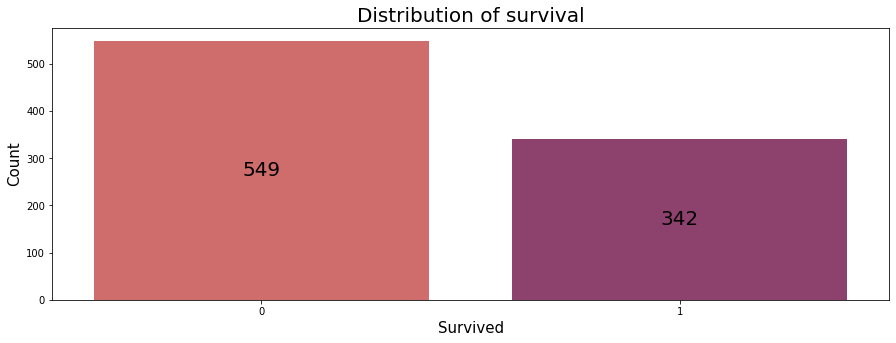

In [28]:
fig, ax = plt.subplots(figsize = (15,5))

ax = sns.countplot(x = "Survived",
                   data = titanic_new,
                   palette = "flare")
ax.set_title("Distribution of survival", fontsize = 20)
ax.set_xlabel("Survived", fontsize = 15)
ax.set_ylabel("Count", fontsize = 15)

for annot in ax.containers:
    ax.bar_label(annot, label_type = "center", size = 20)

#### Age

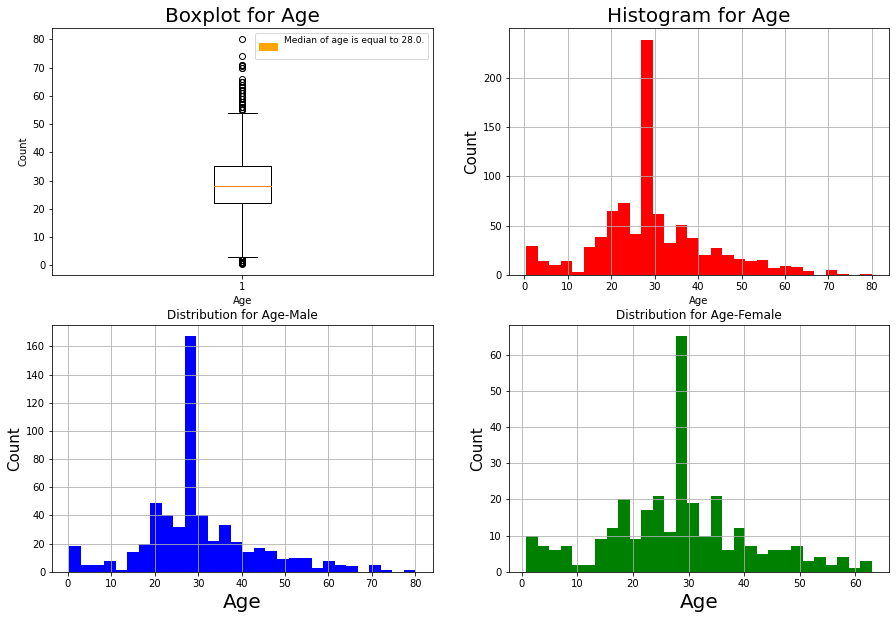

In [29]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(2,2, figsize = (15,10))

# Age Boxplot
axs[0,0].boxplot(titanic_new['Age'])
axs[0,0].set_title("Boxplot for Age", fontsize = 20)
axs[0,0].set_xlabel('Age')
axs[0,0].set_ylabel('Count')
red_patch = mpatches.Patch(color = "orange", label='Median of age is equal to {}.\n'
                                            .format(round(np.median(titanic_new['Age']), 2)))
axs[0,0].legend(handles=[red_patch], prop={'size':9})

# Age histogram
axs[0,1].hist(titanic_new['Age'],
              bins=30,
              color = 'red')
axs[0,1].grid()
axs[0,1].set_title("Histogram for Age", fontsize = 20)
axs[0,1].set_xlabel('Age', fontsize = 10)
axs[0,1].set_ylabel('Count', fontsize = 15)

# Age histogram grouped by Females
axs[1,0].hist(titanic_new[titanic_new["Sex"] == 0]["Age"],
                bins = 30,
                color = 'blue')
axs[1,0].grid()
axs[1,0].set_title("Distribution for Age-Male")
axs[1,0].set_xlabel('Age', fontsize = 20)
axs[1,0].set_ylabel('Count', fontsize = 15)

# Age histogram grouped by Males
axs[1,1].hist(titanic_new[titanic_new["Sex"] == 1]["Age"],
              bins=30,
              color = 'green')
axs[1,1].grid()
axs[1,1].set_title("Distribution for Age-Female")
axs[1,1].set_xlabel('Age', fontsize = 20)
axs[1,1].set_ylabel('Count', fontsize = 15)


plt.show()

#### Sex

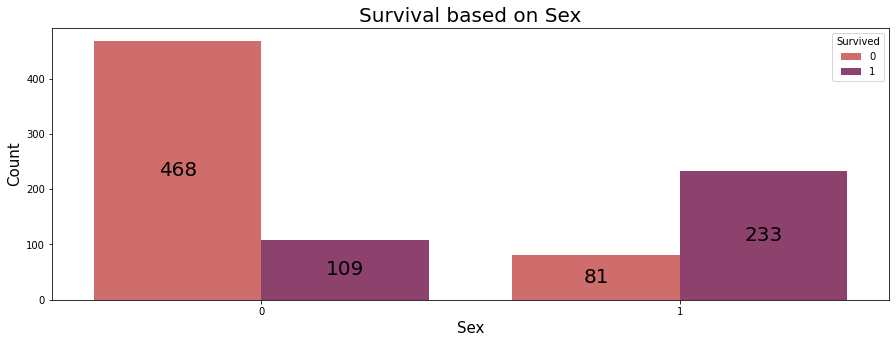

In [30]:
fig, ax = plt.subplots(figsize = (15,5))

ax = sns.countplot(x = "Sex",
                   hue = "Survived",
                   data = titanic_new,
                   palette = "flare")
ax.set_title("Survival based on Sex", fontsize = 20)
ax.set_xlabel("Sex", fontsize = 15)
ax.set_ylabel("Count", fontsize = 15)

for annot in ax.containers:
    ax.bar_label(annot, label_type = "center", size = 20)

#### Pclass

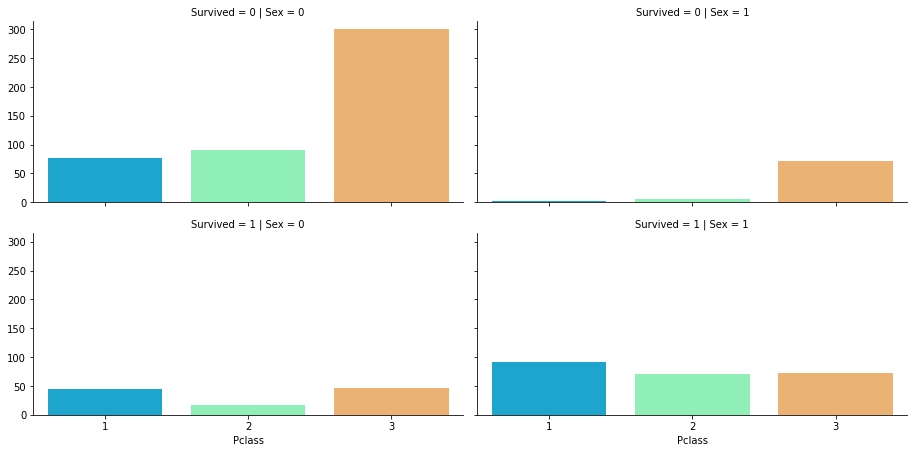

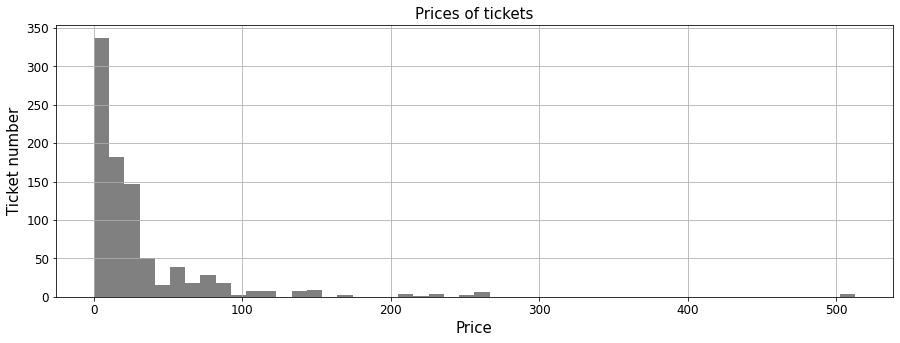

In [84]:
axs_facet_grid = sns.FacetGrid(titanic_new, col="Sex",  row="Survived", height = 3.2, aspect= 2)
axs_facet_grid.map(sns.countplot, "Pclass", palette = "rainbow")
plt.show()

plt.subplots(figsize = (15,5))
titanic_new["Fare"].hist(color="grey",
                         bins=50).set_title("Prices of tickets", fontsize=15)
plt.xlabel("Price", fontsize=15)
plt.ylabel("Ticket number", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### SibSp and Parch

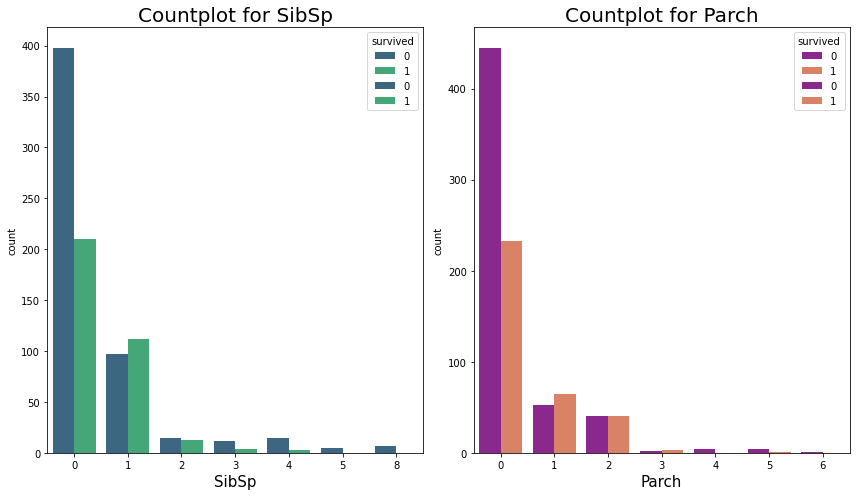

In [38]:
columns = ['SibSp','Parch']

n_rows = 1
n_cols = 2

# The subplot grid and figure size of each graph

fig, axs = plt.subplots(n_rows, n_cols, figsize = (n_cols*6, n_rows*7))

for cols in range(0, n_cols):
    for rows in range(0, n_rows +1):
        
        temp = cols
        ax = axs[cols] # If I distributed it like 2x3 then maybe I would do something like this: ax[s][r]
        palette = ['viridis', 'plasma']
        sns.countplot(titanic_new[columns[temp]], hue = titanic_new['Survived'], ax=ax, palette = palette[cols])
        ax.set_title('Countplot for {}'.format(columns[temp]), fontsize = 20)
        ax.set_xlabel(columns[temp], fontsize = 15)
        ax.legend(title = 'survived', loc = 'upper right')
    
plt.tight_layout()

## 5. Feature selection

### 5.1. Dummying

Embarked variable is not numerical, so in this case I will divide it into levels which will change data into binary values.

In [33]:
titanic_new = pd.get_dummies(titanic_new, columns = ["Embarked"], drop_first = True)


In [34]:
titanic_new.sample() 

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
623,1,3,0,20.0,1,1,15.7417,0,0


In [35]:
titanic_new["Sex"].value_counts()

0    577
1    314
Name: Sex, dtype: int64

### 5.2. Measures of Association

Now, I will try to define which variables will be taken into account in the modelling part. Obviously, my data is not continuous one, so in this case I have to calculate some measures based on the data character.

#### 5.2.1. Nominal variable vs nominal variable

In [36]:
# Survived vs Sex

from scipy.stats import chi2_contingency
  
# defining the table
titanic_survived_sex_table = pd.crosstab(index = titanic_new["Survived"], columns = titanic_new["Sex"])
stat, p, dof, expected = chi2_contingency(titanic_survived_sex_table)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)') # Variables are correlated

p value is 1.1973570627755645e-58
Dependent (reject H0)


In [37]:
# Survived vs Embarked_S

# defining the table
titanic_survived_embarkeds_table = pd.crosstab(index = titanic_new["Survived"], columns = titanic_new["Embarked_S"])
stat, p, dof, expected = chi2_contingency(titanic_survived_embarkeds_table)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)') # Variables are correlated.

p value is 1.1291808110540787e-05
Dependent (reject H0)


In [38]:
# Survived vs Embarked_Q

# defining the table
titanic_survived_embarkedq_table = pd.crosstab(index = titanic_new["Survived"], columns = titanic_new["Embarked_Q"])
stat, p, dof, expected = chi2_contingency(titanic_survived_embarkedq_table)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)') # Variables are not correlated.

p value is 0.9891328942213099
Independent (H0 holds true)


In [39]:
# Embarked_Q vs Embarked_S

# defining the table
titanic_embarkeds_embarkedq_table = pd.crosstab(index = titanic_new["Embarked_S"], columns = titanic_new["Embarked_Q"])
stat, p, dof, expected = chi2_contingency(titanic_embarkeds_embarkedq_table)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)') # Therefore independent variables are correlated which is wrong.

p value is 2.1553492671799716e-49
Dependent (reject H0)


In [40]:
# Embarked_Q vs Sex

# defining the table
titanic_embarkeds_sex_table = pd.crosstab(index = titanic_new["Embarked_S"], columns = titanic_new["Sex"])
stat, p, dof, expected = chi2_contingency(titanic_embarkeds_sex_table)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)') # Therefore independent variables are correlated which is wrong.

p value is 0.0005009382756296058
Dependent (reject H0)


**Result**: Most probably Embarked_Q variable should be ommited. 

#### 5.2.2. Nominal variable vs Ordinal variable

In [41]:
# Survived vs Pclass
from statsmodels.stats.contingency_tables import cochrans_q

titanic_survived_pclass_table = pd.crosstab(index = titanic_new["Survived"], columns = titanic_new["Pclass"])
print(cochrans_q(titanic_survived_pclass_table)) # Variable Pclass is not correlated with Survived


df          2
pvalue      0.36787944117144245
statistic   2.0


Nevertheless, I will also consider Pclass variable as continuous one.

#### 5.2.3. Correlations

In order to use Pearson Correlation, the data should be similar to normal distribution, which is not always so obvious. In order to confirm my thesis, I will conduct Shapiro test in order to assess the normality.


In [42]:
from scipy import stats

numerical_col = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S']

shapiro_pvalues = {}

for columnName in numerical_col:
    shapiro_test = stats.shapiro(titanic_new[columnName])
    shapiro_pvalues.update({columnName:shapiro_test.pvalue})
    
shapiro_pvalues 

{'Survived': 1.7945308393836472e-40,
 'Pclass': 3.3958319924210316e-36,
 'Age': 9.198061005550088e-16,
 'SibSp': 5.74532370373175e-44,
 'Parch': 2.382207389352189e-43,
 'Fare': 1.0789998175301091e-43,
 'Embarked_Q': 0.0,
 'Embarked_S': 1.6044867416519155e-42}

Because of the fact that for each numerical variable, pvalue is lower than 0.05 I have to reject ShapiroWilk's test null hypothesis.
Based on that, the data is normalized so, I should check Spearman correlation.

#### 5.2.3.1. Spearman correlation

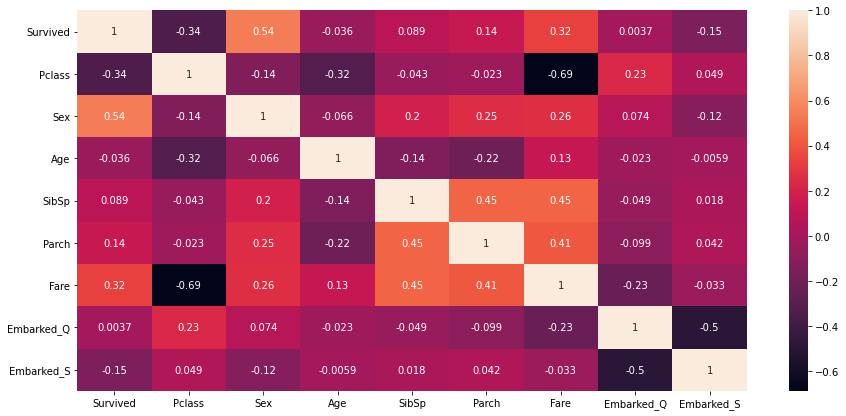

In [43]:
plt.figure (figsize = (15,7)) 
cor = titanic_new.corr(method = "spearman") 
sns.heatmap(cor, annot = True) 
plt.show()

Based on the presented matrix and conducted tests, mostly I am interested in correlations between independent variables ones. I will remove Sex, Pclass and Embarked_Q.

## 6. Modelling Part

Let's introduce Logistic Regression as my based model, which will be my benchmark.

In [44]:
X_variables = titanic_new[["Fare","Age", "SibSp", "Parch", "Embarked_S"]]
Y_variable = titanic_new["Survived"]

In [45]:
sum(Y_variable)/len(Y_variable)

0.3838383838383838

Because of the fact, that the percentage of people who survived is not the same as deaths, I will stratify the data.

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_variables, Y_variable, test_size = 0.2, random_state = 0, stratify = Y_variable)

In [47]:
print(sum(y_train)/len(X_train), sum(y_test)/len(X_test))

0.38342696629213485 0.3854748603351955


Coefficient of survival in train and test datasets is equal, so I can start modelling.

### 6.1. Logistic Regression

In [48]:
# Implementing logistic regression
logistic_regression = LogisticRegression(C = 100)
logistic_regression.fit(X_train, y_train)

# Predictions
train_prediction_logit = logistic_regression.predict(X_train)
test_prediction_logit = logistic_regression.predict(X_test)

#### 6.1.1. Logistic Regression - confusion matrix, ROC_AUC

**************************************************


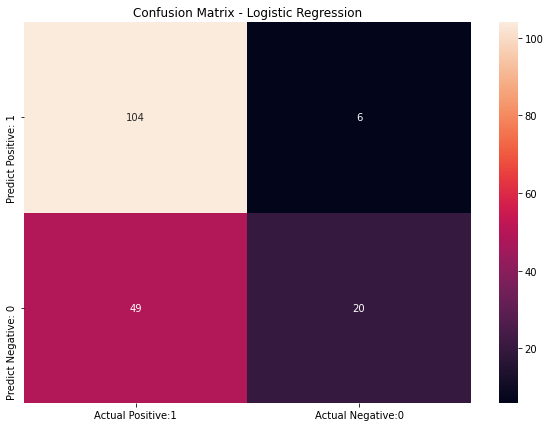

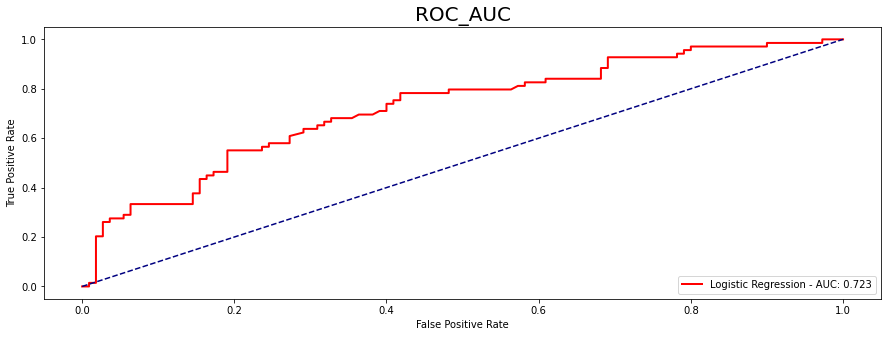

In [49]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

def confusion_matrix_roc_auc():
    
    
    # Confusion_matrix
    plt.figure(figsize=(10, 7))
    confusion_matrix_logistic = confusion_matrix(y_test, test_prediction_logit)
    confusion_matrix_logistic_chart = pd.DataFrame(confusion_matrix_logistic, 
                                   columns = ["Actual Positive:1", "Actual Negative:0"],
                                  index = ["Predict Positive: 1", "Predict Negative: 0"])
    
    sns.heatmap(confusion_matrix_logistic_chart, annot = True, fmt = 'g').set(title = "Confusion Matrix - Logistic Regression")
    
    print("*"*50)
    
    fig, ax = plt.subplots(figsize=(15,5))
    
    #ROC curve plot
    y_pred_proba_logistic = logistic_regression.predict_proba(X_test)[::,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_logistic)
    roc_score_logistic = roc_auc_score(y_test, y_pred_proba_logistic)
    roc_score_logistic = round(roc_score_logistic, 3)
    ax.plot(fpr, tpr, label="Logistic Regression - AUC: {}".format(roc_score_logistic), color="red", linewidth = 2)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC_AUC", fontsize=20)
    ax.legend(loc="lower right")
    ax.legend(loc=4)
    ax.plot([0, 1], [0, 1], color = "navy", linestyle = "--")
    plt.show()
    
confusion_matrix_roc_auc()

In [256]:
y_pred_proba_logistic = logistic_regression.predict_proba(X_test)[::,1]
roc_score_logistic = roc_auc_score(y_test, y_pred_proba_logistic)

import pickle

model_logistic = {"Model": "LogisticRegression",
                      "ROC_AUC_score": roc_score_logistic}

with open("model_logistic.p", "wb") as save:
    pickle.dump(model_logistic, save)

### 6.2. Random Forest

In [51]:
# Implementing random forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

# Predictions
train_prediction_rf = random_forest.predict(X_train)
test_prediction_rf= random_forest.predict(X_test)

#### 6.2.1. Random Forest - confusion matrix, ROC_AUC

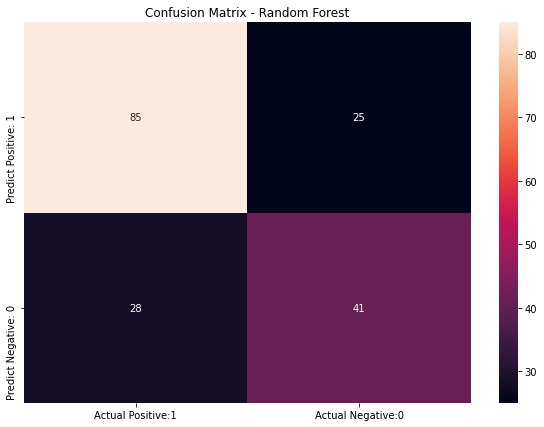

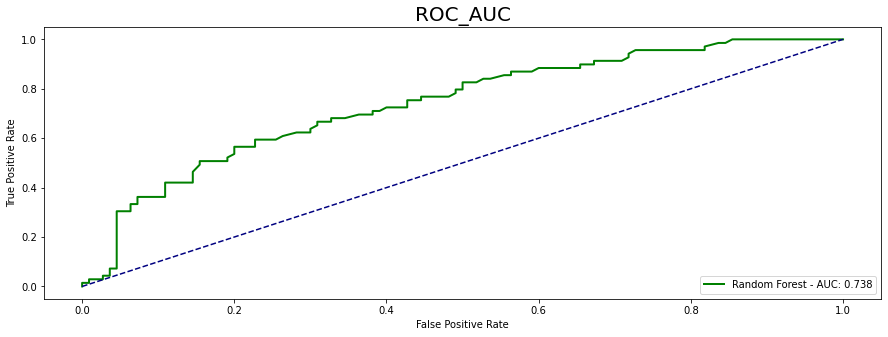

In [52]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

def confusion_matrix_roc_auc_rf():
    
    
    # Confusion_matrix
    plt.figure(figsize=(10, 7))
    confusion_matrix_rf = confusion_matrix(y_test, test_prediction_rf)
    confusion_matrix_rf_chart = pd.DataFrame(confusion_matrix_rf, 
                                   columns = ["Actual Positive:1", "Actual Negative:0"],
                                  index = ["Predict Positive: 1", "Predict Negative: 0"])
    
    sns.heatmap(confusion_matrix_rf_chart, annot = True, fmt = 'g').set(title = "Confusion Matrix - Random Forest")
    
    
    fig, ax = plt.subplots(figsize=(15,5))
    
    #ROC curve plot
    y_pred_proba_rf = random_forest.predict_proba(X_test)[::,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
    roc_score_rf = roc_auc_score(y_test, y_pred_proba_rf)
    roc_score_rf = round(roc_score_rf, 3)
    ax.plot(fpr, tpr, label="Random Forest - AUC: {}".format(roc_score_rf), color="green", linewidth = 2)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC_AUC", fontsize=20)
    ax.legend(loc="lower right")
    ax.legend(loc=4)
    ax.plot([0, 1], [0, 1], color = "navy", linestyle = "--")
    plt.show()
    
confusion_matrix_roc_auc_rf()

#### 6.2.2. Cross-validation wrapper. Hyperparameters. Feature importance

In [53]:
features = list(X_variables.columns)
target = "Survived"

In [54]:
# Wrapper
def CVTestRFClass(nFolds = 5, randomState=0, print_results = False, show_features=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Lists for results:
    testResults_rf = []
    trainResults_rf = []
    predictions_rf = []
    indices_rf = []
    feature_importance = 0

    for train, test in kf.split(titanic_new.index.values):
        random_forest_estimator = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        random_forest_estimator.fit(titanic_new.iloc[train][features], titanic_new.iloc[train][target])

        predsTrain_rf = random_forest_estimator.predict_proba(titanic_new.iloc[train][features])[:,1]
        preds_rf = random_forest_estimator.predict_proba(titanic_new.iloc[test][features])[:,1]
        
        predictions_rf.append(preds_rf.tolist().copy())
        
        indices_rf.append(titanic_new.iloc[test].index.tolist().copy())
        
        trainScore_rf = roc_auc_score(titanic_new[target].iloc[train], predsTrain_rf)
        testScore_rf = roc_auc_score(titanic_new[target].iloc[test], preds_rf)
        
        trainResults_rf.append(trainScore_rf)
        testResults_rf.append(testScore_rf)
        
        # Results
        if print_results == True:
            print("Train AUC:", trainScore_rf,
                  "Valid AUC:", testScore_rf)
        
        # Feature importance
        if show_features == True:
            if len(testResults_rf) == 1:
                feature_importance = pd.DataFrame({"Features": features, 
                                                  "Importance_model_0": np.round(random_forest_estimator.feature_importances_, 2)})
            else:
                feature_importance_temp = pd.DataFrame({"Features": features, 
                                                  "Importance_model_{}".format(len(testResults_rf)): np.round(random_forest_estimator.feature_importances_, 2)})
                feature_importance = pd.concat([feature_importance, feature_importance_temp.iloc[:,1]], axis = 1)
            
            
    return trainResults_rf, testResults_rf, predictions_rf, indices_rf, feature_importance

trainResults, testResults, predictions, indices, feature_importance = CVTestRFClass(print_results = True)
print(np.mean(testResults))

Train AUC: 0.9934958739058968 Valid AUC: 0.7773386034255599
Train AUC: 0.9950311332503113 Valid AUC: 0.691340594325669
Train AUC: 0.9935240815522505 Valid AUC: 0.7577586206896552
Train AUC: 0.9943835616438357 Valid AUC: 0.7241495226569854
Train AUC: 0.9948886176380837 Valid AUC: 0.7355224640448007
0.7372219610285341


On a traning dataset I've reach almost 100% fit, so they are overfitted. Let's dive into features and adjust some values for them.

In [55]:
# Feature importance for models
trainResults, testResults, predictions, indices, feature_importance = CVTestRFClass(show_features = True)
print(feature_importance.sort_values(by = ["Importance_model_0"], ascending = False))

     Features  Importance_model_0  Importance_model_2  Importance_model_3  \
0        Fare              0.4600              0.4600              0.4600   
1         Age              0.3800              0.3600              0.3700   
2       SibSp              0.0800              0.0900              0.0800   
3       Parch              0.0500              0.0500              0.0500   
4  Embarked_S              0.0300              0.0300              0.0300   

   Importance_model_4  Importance_model_5  
0              0.4600              0.4600  
1              0.3700              0.3600  
2              0.0800              0.0900  
3              0.0500              0.0500  
4              0.0300              0.0400  


Results are definitely similar, so the most important variables are Fare and Age. Let's look for parameters to assess their limit for hyperparameters tuning.

In [56]:
# N_estimators

for k in [10, 25, 50, 100, 200, 500, 1000]:
    trainResults, testResults, predictions, indices, feature_importance = CVTestRFClass(
                                                                            
                                                                            n_estimators=k)
    print(f'N_estimators are equal to {k}', np.mean(trainResults), np.mean(testResults))

N_estimators are equal to 10 0.9871640070679026 0.7103323218755923
N_estimators are equal to 25 0.9920998209524736 0.7323397041272623
N_estimators are equal to 50 0.993487065633753 0.7356103959477069
N_estimators are equal to 100 0.9942646535980755 0.7372219610285341
N_estimators are equal to 200 0.9944438139075471 0.7404407653742234
N_estimators are equal to 500 0.994555727238108 0.740227213170588
N_estimators are equal to 1000 0.9946371277204167 0.7421623555018664


In [57]:
# Max_depth

for k in range(2,14,2):
    trainResults, testResults, predictions, indices, feature_importance = CVTestRFClass(n_estimators= 100, 
                                                                                        max_depth=k)
    
    print(f'Max_depth is equal to {k}', np.mean(trainResults), np.mean(testResults))

Max_depth is equal to 2 0.7667033415175898 0.7368291219607086
Max_depth is equal to 4 0.8182992596196422 0.7514430856951018
Max_depth is equal to 6 0.8691573049278265 0.7603563329889069
Max_depth is equal to 8 0.924237177824742 0.7607593209860507
Max_depth is equal to 10 0.9676360331317229 0.7552220369713295
Max_depth is equal to 12 0.9869719307371089 0.7519820858638123


The highest value for testResults is for max_depth = 6. Let's use this knowledge in the final RandomForest model.

In [58]:
# min_samples_split
for k in [2, 4, 6, 8, 10, 15, 20]:
    trainResults, testResults, predictions, indices, feature_importance = CVTestRFClass(print_results = False, 
                                                                                        n_estimators=100, 
                                                                                        max_depth=6,
                                                                                        min_samples_split=k)
    print(k, np.mean(testResults))

2 0.7603563329889069
4 0.7600686368214655
6 0.7596981823738832
8 0.7587574819181515
10 0.7584256381062158
15 0.7557880040199751
20 0.7576281317577267


Minimal samples split should be also equal to six. Let's calculate minimal sample leaf.


In [59]:
for k in range(1,7):
    trainResults, testResults, predictions, indices, feature_importance = CVTestRFClass(print_results = False, 
                                                                                        n_estimators=100, 
                                                                                        max_depth=6,
                                                                                        min_samples_split=6,
                                                                                        min_samples_leaf=k)
    print(k, np.mean(testResults))

1 0.7596981823738832
2 0.7572036113422884
3 0.7575598046630665
4 0.7547034740186306
5 0.7515106383783767
6 0.75417866324027


Minimal samples leaf should be equal to 2. Let's save our model, with the obtained results.


In [60]:
trainResults, testResults, predictions, indices, feature_importance = CVTestRFClass(print_results = False,
                                                                                    n_estimators=100, 
                                                                                    max_depth=6,
                                                                                    min_samples_split=6, 
                                                                                    min_samples_leaf=2)
print(k, np.mean(testResults))

6 0.7572036113422884


#### 6.2.3. Tuning of hyperparameters

In [61]:
# Creating param grid

param_grid_random_forest = {"n_estimators": [int(x) for x in np.linspace(50, 110, 10)],
                            "max_depth": [int(x) for x in range(2,10,2)],
                            "min_samples_split": [int(x) for x in range(4,8)],
                            "min_samples_leaf":[int(x) for x in range(1,4)]}

grid_search_random_forest = RandomizedSearchCV(estimator=random_forest,
                           param_distributions=param_grid_random_forest,
                           cv=5,
                           random_state = 0)

grid_search_random_forest.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [2, 4, 6, 8],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [4, 5, 6, 7],
                                        'n_estimators': [50, 56, 63, 70, 76, 83,
                                                         90, 96, 103, 110]},
                   random_state=0)

In [62]:
grid_search_random_forest.best_params_

{'n_estimators': 70,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_depth': 6}

In [63]:
# Final result
y_pred_proba_rf_final = grid_search_random_forest.predict_proba(X_test)[::,1]
roc_score_rf_final = roc_auc_score(y_test, y_pred_proba_rf_final)
roc_score_rf_final

0.7506587615283267

In [255]:
import pickle

model_random_forest_final = {"Model": "RF",
                      "ROC_AUC_score": roc_score_rf_final}

with open("model_random_forest_final.p", "wb") as save:
    pickle.dump(model_random_forest_final, save)

### 6.3. ADABoost

In [65]:
# Implementing random forest
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, y_train)

# Predictions
train_prediction_ada = ada_boost.predict(X_train)
test_prediction_ada = ada_boost.predict(X_test)


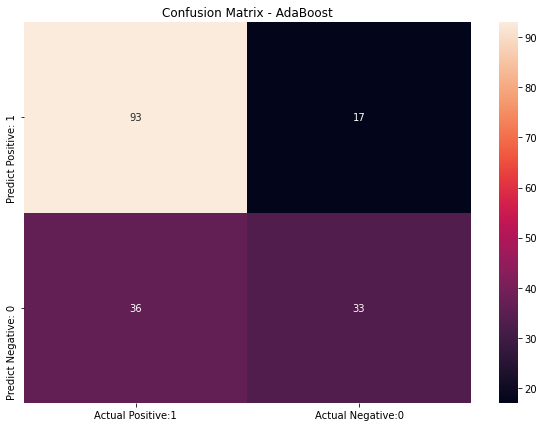

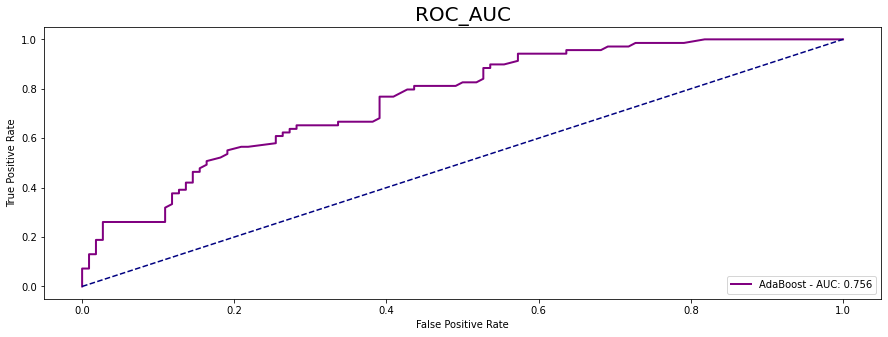

In [66]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

def confusion_matrix_roc_auc_ada():
    
    
    # Confusion_matrix
    plt.figure(figsize=(10, 7))
    confusion_matrix_ada = confusion_matrix(y_test, test_prediction_ada)
    confusion_matrix_ada_chart = pd.DataFrame(confusion_matrix_ada, 
                                   columns = ["Actual Positive:1", "Actual Negative:0"],
                                  index = ["Predict Positive: 1", "Predict Negative: 0"])
    
    sns.heatmap(confusion_matrix_ada_chart, annot = True, fmt = 'g').set(title = "Confusion Matrix - AdaBoost")
    
    
    fig, ax = plt.subplots(figsize=(15,5))
    
    #ROC curve plot
    y_pred_proba_ada = ada_boost.predict_proba(X_test)[::,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_ada)
    roc_score_ada = roc_auc_score(y_test, y_pred_proba_ada)
    roc_score_ada = round(roc_score_ada, 3)
    ax.plot(fpr, tpr, label="AdaBoost - AUC: {}".format(roc_score_ada), color="purple", linewidth = 2)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC_AUC", fontsize=20)
    ax.legend(loc="lower right")
    ax.legend(loc=4)
    ax.plot([0, 1], [0, 1], color = "navy", linestyle = "--")
    plt.show()
    
confusion_matrix_roc_auc_ada()

#### 6.3.2. Cross-validation wrapper. Hyperparameters. Feature importance

In [67]:
def CVTestAdaClass(nFolds = 5, randomState=99, print_results = False, show_features=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # List for results:
    testResults_ada = []
    trainResults_ada = []
    predictions_ada = []
    indices_ada = []
    feature_importance = 0

    
    for train, test in kf.split(titanic_new.index.values):
        ada_boost_estimator = AdaBoostClassifier(*args, **kwargs, random_state=randomState)
        ada_boost_estimator.fit(titanic_new.iloc[train][features], titanic_new.iloc[train][target])

        predsTrain_ada = ada_boost_estimator.predict_proba(titanic_new.iloc[train][features])[:,1]
        preds_ada = ada_boost_estimator.predict_proba(titanic_new.iloc[test][features])[:,1]
        
        predictions_ada.append(preds_ada.tolist().copy())

        indices_ada.append(titanic_new.iloc[test].index.tolist().copy())

        trainScore_ada = roc_auc_score(titanic_new[target].iloc[train], predsTrain_ada)
        testScore_ada = roc_auc_score(titanic_new[target].iloc[test], preds_ada)
        
        trainResults_ada.append(trainScore_ada)
        testResults_ada.append(testScore_ada)
        
        # Print results
        if print_results == True:
            print("Train AUC:", trainScore_ada,
                  "Valid AUC:", testScore_ada)
            
        # Print feature importance   
        if show_features == True:
            if len(testResults_ada) == 1:
                feature_importance = pd.DataFrame({"Features": features, 
                                                  "Importance_model_0": np.round(ada_boost_estimator.feature_importances_, 2)})
            else:
                feature_importance_temp = pd.DataFrame({"Features": features, 
                                                  "Importance_model_{}".format(len(testResults_ada)): np.round(ada_boost_estimator.feature_importances_, 2)})
                feature_importance = pd.concat([feature_importance, feature_importance_temp.iloc[:,1]], axis = 1)
            
            
    return trainResults_ada, testResults_ada, predictions_ada, indices_ada, feature_importance

trainResults, testResults, predictions, indices, feature_importance = CVTestAdaClass(print_results = True)
print(np.mean(testResults))

Train AUC: 0.8167132030315117 Valid AUC: 0.7787610619469028
Train AUC: 0.833765816528272 Valid AUC: 0.670379711363318
Train AUC: 0.8134532134532134 Valid AUC: 0.737335460710012
Train AUC: 0.812446134347275 Valid AUC: 0.7913949622810382
Train AUC: 0.8168700705687008 Valid AUC: 0.718233158531666
0.7392208709665874


In [68]:
# N_estimators

for k in [10, 25, 50, 100, 200, 500, 1000]:
    trainResults, testResults, predictions, indices, feature_importance = CVTestAdaClass(n_estimators=k)
    print(f'N_estimators are equal to {k}', np.mean(trainResults), np.mean(testResults))

N_estimators are equal to 10 0.773015785636537 0.7233057156044007
N_estimators are equal to 25 0.8005999039883716 0.7322392742503514
N_estimators are equal to 50 0.8186496875857946 0.7392208709665874
N_estimators are equal to 100 0.8338834153207866 0.7500351819603539
N_estimators are equal to 200 0.8503572561136481 0.7500664735460634
N_estimators are equal to 500 0.8734699383657507 0.7494809170788502
N_estimators are equal to 1000 0.8910005174061416 0.7428302796774888


In [69]:
# Learning_Rate

for k in [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]:
    trainResults, testResults, predictions, indices, feature_importance = CVTestAdaClass(n_estimators=100,
                                                                                         learning_rate = k)
    print(f'N_estimators are equal to {k}', np.mean(trainResults), np.mean(testResults))

N_estimators are equal to 0.1 0.7869300411795862 0.7471959400348153
N_estimators are equal to 0.2 0.7966464670035848 0.7491969039120482
N_estimators are equal to 0.3 0.8035506584144656 0.7464319225867779
N_estimators are equal to 0.5 0.814771523998062 0.7474342849880994
N_estimators are equal to 0.7 0.8226540971932705 0.7490172748030528
N_estimators are equal to 0.9 0.8298987088004324 0.7511248285933909


In [70]:
# Algorithm

for k in ['SAMME', 'SAMME.R']:
    trainResults, testResults, predictions, indices, feature_importance = CVTestAdaClass(n_estimators=100,
                                                                                         learning_rate = 0.2,
                                                                                         algorithm = k)
    print(f'N_estimators are equal to {k}', np.mean(trainResults), np.mean(testResults))

N_estimators are equal to SAMME 0.7525046118324448 0.7205696500306591
N_estimators are equal to SAMME.R 0.7966464670035848 0.7491969039120482


In [71]:
# Creating param grid

param_grid_ada = {"n_estimators": [int(x) for x in np.linspace(50, 110, 10)],
                            "learning_rate": [0.15, 0.16, 0.17, 0.18, 0.19, 0.20]}

grid_search_ada = RandomizedSearchCV(estimator=ada_boost,
                           param_distributions=param_grid_ada,
                           cv=5,
                           random_state = 0)

grid_search_ada.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(),
                   param_distributions={'learning_rate': [0.15, 0.16, 0.17,
                                                          0.18, 0.19, 0.2],
                                        'n_estimators': [50, 56, 63, 70, 76, 83,
                                                         90, 96, 103, 110]},
                   random_state=0)

In [72]:
grid_search_ada.best_params_

{'n_estimators': 90, 'learning_rate': 0.17}

In [73]:
# Final result
y_pred_proba_ada_final = grid_search_ada.predict_proba(X_test)[::,1]
roc_score_ada_final = roc_auc_score(y_test, y_pred_proba_ada_final)
roc_score_ada_final

0.7612648221343874

In [254]:
model_ada_boost_final = {"Model": "AdaBoost",
                      "ROC_AUC_score": roc_score_ada_final}

with open("model_ada_boost_final.p", "wb") as save:
    pickle.dump(model_ada_boost_final, save)

### 6.4. XGBoost

In [75]:
xgboost_titanic = xgb.XGBClassifier(eval_metric = 'logloss', random_state = 0)
xgboost_titanic.fit(X_train, y_train)
train_prediction_xgb = xgboost_titanic.predict(X_train)
test_prediction_xgb = xgboost_titanic.predict(X_test)

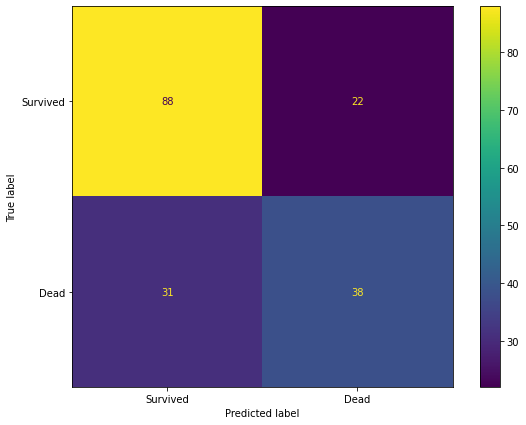

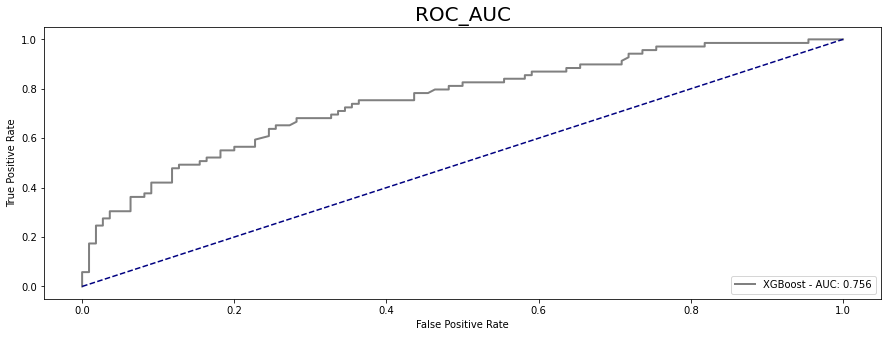

In [76]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

def confusion_matrix_roc_auc_xgb():
    
    fig, ax1 = plt.subplots(figsize=(10,7))
    
    # Confusion_matrix
    plot_confusion_matrix(xgboost_titanic,
                          X_test,
                          y_test,
                          display_labels = ["Survived", "Dead"],
                          ax = ax1)
    
    fig, ax2 = plt.subplots(figsize=(15,5))
    
    #ROC curve plot
    y_pred_proba_xgb = xgboost_titanic.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)
    roc_score_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
    roc_score_xgb = round(roc_score_xgb, 3)
    ax2.plot(fpr, tpr, label="XGBoost - AUC: {}".format(roc_score_xgb), color="grey", linewidth = 2)
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("ROC_AUC", fontsize=20)
    ax2.legend(loc="lower right")
    ax2.legend(loc=4)
    ax2.plot([0, 1], [0, 1], color = "navy", linestyle = "--")
    plt.show()
    
confusion_matrix_roc_auc_xgb()

#### 6.4.2. Cross-validation wrapper. Hyperparameters. Feature importance

In [77]:
# Wrapper
def CVTestXGBClass(nFolds = 5, randomState=0, print_results = False, show_features=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Lists for results:
    testResults_xgb = []
    trainResults_xgb = []
    predictions_xgb = []
    indices_xgb = []
    feature_importance = 0

    for train, test in kf.split(titanic_new.index.values):
        xgb_estimator = xgb.XGBClassifier(eval_metric = 'logloss', *args, **kwargs, random_state=randomState, n_jobs=-1)
        xgb_estimator.fit(titanic_new.iloc[train][features], titanic_new.iloc[train][target])

        predsTrain_xgb = xgb_estimator.predict_proba(titanic_new.iloc[train][features])[:,1]
        preds_xgb = xgb_estimator.predict_proba(titanic_new.iloc[test][features])[:,1]
        
        predictions_xgb.append(preds_xgb.tolist().copy())
        
        indices_xgb.append(titanic_new.iloc[test].index.tolist().copy())
        
        trainScore_xgb = roc_auc_score(titanic_new[target].iloc[train], predsTrain_xgb)
        testScore_xgb = roc_auc_score(titanic_new[target].iloc[test], preds_xgb)
        
        trainResults_xgb.append(trainScore_xgb)
        testResults_xgb.append(testScore_xgb)
        
        # Results
        if print_results == True:
            print("Train AUC:", trainScore_xgb,
                  "Valid AUC:", testScore_xgb)
        
        # Feature importance
        if show_features == True:
            if len(testResults_xgb) == 1:
                feature_importance = pd.DataFrame({"Features": features, 
                                                  "Importance_model_0": np.round(xgb_estimator.feature_importances_, 2)})
            else:
                feature_importance_temp = pd.DataFrame({"Features": features, 
                                                  "Importance_model_{}".format(len(testResults_xgb)): np.round(xgb_estimator.feature_importances_, 2)})
                feature_importance = pd.concat([feature_importance, feature_importance_temp.iloc[:,1]], axis = 1)
            
            
    return trainResults_xgb, testResults_xgb, predictions_xgb, indices_xgb, feature_importance

trainResults, testResults, predictions, indices, feature_importance = CVTestXGBClass(print_results = True)
print(np.mean(testResults))

Train AUC: 0.9799953273757374 Valid AUC: 0.7592885375494072
Train AUC: 0.9877833125778333 Valid AUC: 0.7201828694366008
Train AUC: 0.9851152368758002 Valid AUC: 0.730316091954023
Train AUC: 0.9800456621004565 Valid AUC: 0.7496974586526826
Train AUC: 0.9827416675143253 Valid AUC: 0.7115947562682958
0.7342159427722018


There is definitely an overfitting issue. In this scenario, the best case is to increase training dataset or thinking about **early stopping**. Nevertheless, as I did previously, I will dive into my hyperparameters and select some limit value, until which I will conduct Grid Search.

In [141]:
# Max_depth
for depth in range(3,12):
    trainResults, testResults, predictions, indices, hists = CVTestXGBClass(max_depth=depth)
    print(f'Max_depth is equal to {depth}', np.mean(trainResults), np.mean(testResults))

Max_depth is equal to 3 0.9274995695505535 0.7383475923526747
Max_depth is equal to 4 0.9586283009420956 0.7348700477541212
Max_depth is equal to 5 0.9745343787552949 0.7396263661918582
Max_depth is equal to 6 0.9831362412888305 0.7342159427722018
Max_depth is equal to 7 0.9894696357776027 0.7357076497151636
Max_depth is equal to 8 0.9917939424105573 0.7332537469263882
Max_depth is equal to 9 0.9927402485771196 0.7362124225268671
Max_depth is equal to 10 0.9935798042894278 0.7325728921667956
Max_depth is equal to 11 0.9941129627073039 0.7329551564234443


Max_depth = 5 seems to be good, because predicted values are not overfitted and train result is the highest.

In [246]:
# Subsample
for subsample in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1]:
    trainResults, testResults, predictions, indices, hists = CVTestXGBClass(max_depth=7,
                                                                            subsample = subsample)
    print(f'Subsample is equal to {subsample}', np.mean(trainResults), np.mean(testResults))

Subsample is equal to 0.01 0.6805745062836993 0.6689661658573135
Subsample is equal to 0.05 0.7640120265841147 0.6762156994526243
Subsample is equal to 0.1 0.8350966536803794 0.7154795387182393
Subsample is equal to 0.2 0.9082008771330015 0.7023601397558805
Subsample is equal to 0.3 0.9460930640825893 0.7104499131948847
Subsample is equal to 0.4 0.9695596013657133 0.7267434472768166
Subsample is equal to 0.5 0.9804289429620289 0.7231007889437052
Subsample is equal to 0.8 0.991383360245892 0.7311941939575568
Subsample is equal to 1 0.9894696357776027 0.7357076497151636


In my case subsample should be the highest as it could be, the nearer the 1 the better.

In [247]:
# Gamma
for colsample_bytree in [0.1, 0.2, 0.5, 0.8, 1]:
    trainResults, testResults, predictions, indices, hists = CVTestXGBClass(max_depth=7,
                                                                            learning_rate = 0.3,
                                                                            gamma = colsample_bytree)
    print(f'Colsample_bytree is equal to {colsample_bytree}', np.mean(trainResults), np.mean(testResults))

Colsample_bytree is equal to 0.1 0.9873423615916501 0.7345307146426222
Colsample_bytree is equal to 0.2 0.978901022224948 0.7407285457568514
Colsample_bytree is equal to 0.5 0.9599981577652128 0.7519401889922788
Colsample_bytree is equal to 0.8 0.9393773922022397 0.7519095661660001
Colsample_bytree is equal to 1 0.9288369669751632 0.7537877556078889


Similar situation to previous point, colsample_bytree should be nearly 1.

In [248]:
# lambda
for lambdaX in [0,3,5,10,20,50,100]:
    trainResults, testResults, predictions, indices, hists = CVTestXGBClass(max_depth=3,
                                                                            learning_rate = 02.,
                                                                            reg_lambda = lambdaX)
    print(f'Lambda is equal to {lambdaX}', np.mean(trainResults), np.mean(testResults))

Lambda is equal to 0 0.5462376059054298 0.5581055658507228
Lambda is equal to 3 0.9833464706249396 0.7145543187930653
Lambda is equal to 5 0.9534220058874704 0.7050913938199859
Lambda is equal to 10 0.9770562654645989 0.7270641101775703
Lambda is equal to 20 0.9615528366452226 0.7270605419529649
Lambda is equal to 50 0.9322073014056844 0.7305131255508389
Lambda is equal to 100 0.9087982531338339 0.7401653630245836


In my case, the value of reg_lambda should be around 10-20.

In [251]:
# Creating param grid

param_grid_xgb = {"max_depth":[5,6,7,8],
                  "lambda": [10,15,20,25],
                  "colsample_bytree": [0.9, 0.95, 1],
                  "subsample": [0.9, 0.95, 1]}

grid_search_xgb = RandomizedSearchCV(estimator=xgboost_titanic,
                           param_distributions=param_grid_xgb,
                           scoring = "accuracy", 
                           verbose = 1,
                           cv=5,
                           random_state=0)

grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=0,
                                           gpu_id=-1, importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_cons...
                                           n_estimators=100, n_jobs=4,
                                           num_parallel_tree=1,
  

In [243]:
grid_search_xgb.best_params_

{'subsample': 1, 'max_depth': 5, 'lambda': 20, 'colsample_bytree': 0.9}

In [252]:
# Final result
y_pred_proba_xgb_final = grid_search_xgb.predict_proba(X_test)[::,1]
roc_score_xgb_final = roc_auc_score(y_test, y_pred_proba_xgb_final)
roc_score_xgb_final

0.7701581027667984

In [253]:
model_xgb_final = {"Model": "XGBoost",
                    "ROC_AUC_score": roc_score_xgb_final}

with open("model_xgb_final.p", "wb") as save:
    pickle.dump(model_xgb_final, save)